# Проект: исследование поведения пользователей мобильного приложения 

**Цель исследования:**

Исследовать поведение пользователей мобильного приложения, через которое продают продукты питания.

**Задачи:**

1) Изучить воронку продаж:
 - как пользователи доходят до покупки,
 - сколько пользователей доходит до покупки, 
 - сколько пользователей «застревает» на предыдущих шагах и на каких именно.

2) Исследовать результаты A/A/B-эксперимента.


In [53]:
# импортируем нужные для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math as mth
from scipy import stats as st

from termcolor import colored
from plotly import graph_objects as go


## Открытие файл с данными и изучение общей информации

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.



In [54]:
# загрузим данные 

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [55]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Наблюдения**

- 244126 строк, пропусков нет, но перепроверить
- заменить формат данных для даты с unix time на datetime
- поменять названия столбцов 
- проверить на наличие дубликатов 


---------------------------------------

## Предобработка данных


In [57]:
data.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [58]:
# заменим названия столбцов

data.columns = ['event_name', 'device_id', 'event_timestep', 'exp_id']

In [59]:
# добавим столбец с датой и временем
data['event_dt'] = pd.to_datetime(data['event_timestep'],  unit='s')  

# добавим столбец только с датой 
data['event_date'] = pd.to_datetime(data['event_dt']).dt.date  

In [60]:
# проверим изменения
data.head()

,event_name,device_id,event_timestep,exp_id,event_dt,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [61]:
# проверим на наличие пропусков
data.isna().sum()

event_name        0
device_id         0
event_timestep    0
exp_id            0
event_dt          0
event_date        0
dtype: int64

In [62]:
# проверим какие значения входят в столбец с  номерами экспериментов
data['exp_id'].unique()

array([246, 248, 247])

In [63]:
# проверим нет ли неявных дубликатов в названиях событий
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [64]:
# проверим на наличие явных дубликатов 
print('Кол-во дубликатов:', data.duplicated().sum())

Кол-во дубликатов: 413


In [65]:
duplicated_df = data[data.duplicated()].head(10) # датафрейм с дубликатами
duplicated_df 


,event_name,device_id,event_timestep,exp_id,event_dt,event_date
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
5641,CartScreenAppear,4248762472840564256,1564637764,248,2019-08-01 05:36:04,2019-08-01
5875,PaymentScreenSuccessful,6427012997733591237,1564638452,248,2019-08-01 05:47:32,2019-08-01
7249,OffersScreenAppear,7224691986599895551,1564641846,246,2019-08-01 06:44:06,2019-08-01
8065,CartScreenAppear,8189122927585332969,1564643929,248,2019-08-01 07:18:49,2019-08-01
9179,MainScreenAppear,2230705996155527339,1564646087,246,2019-08-01 07:54:47,2019-08-01


In [66]:
data.query('device_id == 5613408041324010552')

,event_name,device_id,event_timestep,exp_id,event_dt,event_date
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
104383,MainScreenAppear,5613408041324010552,1564857690,248,2019-08-03 18:41:30,2019-08-03
104628,MainScreenAppear,5613408041324010552,1564858279,248,2019-08-03 18:51:19,2019-08-03
104637,MainScreenAppear,5613408041324010552,1564858297,248,2019-08-03 18:51:37,2019-08-03
145276,MainScreenAppear,5613408041324010552,1564986831,248,2019-08-05 06:33:51,2019-08-05
145550,MainScreenAppear,5613408041324010552,1564987332,248,2019-08-05 06:42:12,2019-08-05
205860,MainScreenAppear,5613408041324010552,1565112335,248,2019-08-06 17:25:35,2019-08-06
205869,MainScreenAppear,5613408041324010552,1565112351,248,2019-08-06 17:25:51,2019-08-06
205915,MainScreenAppear,5613408041324010552,1565112400,248,2019-08-06 17:26:40,2019-08-06


In [67]:
# удалим дубликаты из данных
data = data.drop_duplicates().reset_index()

**Наблюдения**

- Были изменены названия столбцов.
- К датафрему были добавлены столбцы с датой и временем и только с датой. 
- Пропусков в данных не было обнаружено. 
- Из данных было удалено 413 явных дубликата. 


In [68]:
# Проверим есть ли пересечения между группами:
  
group246 = data[data['exp_id']==246]
group247 = data[data['exp_id']==247]
group248 = data[data['exp_id']==248]

id246 = group246['device_id']
id247 = group247['device_id']

#246 и 247
display(group247.query('device_id in @id246'))

#246 и 248
display(group248.query('device_id in @id246'))

#247 и 248
group248.query('device_id in @id247')


,index,event_name,device_id,event_timestep,exp_id,event_dt,event_date


,index,event_name,device_id,event_timestep,exp_id,event_dt,event_date


,index,event_name,device_id,event_timestep,exp_id,event_dt,event_date


**Наблюдения**

Пересечений между группами обнаружено не было. 

-----------------------------------------------

## Изучение и проверка данных


### Сколько всего событий в логе?


In [69]:
print('Всего событий в логе:', len(data))

Всего событий в логе: 243713


In [70]:
print('Событий в группу А1:', len(data.query('exp_id == 246')))
print('Событий в группу А2:', len(data.query('exp_id == 247')))
print('Событий в группу B:', len(data.query('exp_id == 248')))

Событий в группу А1: 80181
Событий в группу А2: 77950
Событий в группу B: 85582


In [71]:
print('Кол-во событий в группе В больше, чем в группе А1 на', 
      round((len(data.query('exp_id == 248'))/len(data.query('exp_id == 246')) - 1)*100, 2), '%') 
print('Кол-во событий в группе В больше, чем в группе А2 на', 
      round((len(data.query('exp_id == 248'))/len(data.query('exp_id == 247')) - 1)*100, 2), '%') 

Кол-во событий в группе В больше, чем в группе А1 на 6.74 %
Кол-во событий в группе В больше, чем в группе А2 на 9.79 %


### Сколько всего пользователей в логе?

In [73]:
print('Всего уникальных пользователей в логе:', len(data['device_id'].unique()))

Всего уникальных пользователей в логе: 7551


In [74]:
print('Кол-во уникальных пользователей в группе А1:', len(data.query('exp_id == 246')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе А2:', len(data.query('exp_id == 247')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе B:', len(data.query('exp_id == 248')['device_id'].unique()))

Кол-во уникальных пользователей в группе А1: 2489
Кол-во уникальных пользователей в группе А2: 2520
Кол-во уникальных пользователей в группе B: 2542


### Сколько в среднем событий приходится на пользователя?

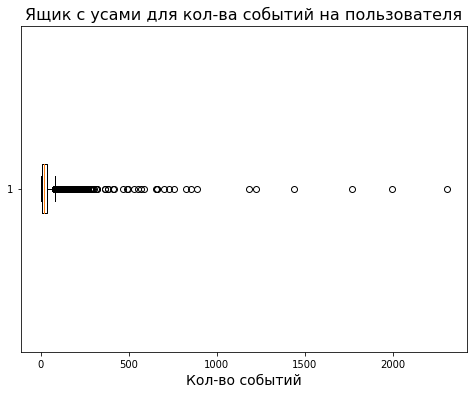

In [75]:
#  посчитаем кол-во собыйтий на каждого уникального пользователя
event_per_user = data.groupby(by='device_id')['event_name'].count()

# построим ящик с усами 
fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Ящик с усами для кол-ва событий на пользователя', fontsize=16)
ax1.boxplot(event_per_user, vert=False)
ax1.set_xlabel('Кол-во событий', fontsize=14);

**Наблюдения**

По ящику с усами видим, что в данных пресутствуют аномальные пользователе, посетившие приложение очень много раз, более 100.

Для оценки среднего кол-ва событий на пользователя будем использовать медианное значение.

In [76]:
print('Среднее кол-во событий на пользователя:', round(len(data)/len(data['device_id'].unique()), 2))

Среднее кол-во событий на пользователя: 32.28


In [77]:
print('Медианное значение кол-ва событий на пользователя:', event_per_user.median())

Медианное значение кол-ва событий на пользователя: 20.0


In [78]:
print('Медианное значение событий на пользователя в группе А1:', 
     data.query('exp_id == 246').groupby(by='device_id')['event_name'].count().median())
print('Медианное значение событий на пользователя в группе А2:', 
      data.query('exp_id == 247').groupby(by='device_id')['event_name'].count().median())
print('Медианное значение событий на пользователя в группе B:', 
     data.query('exp_id == 248').groupby(by='device_id')['event_name'].count().median())

Медианное значение событий на пользователя в группе А1: 19.0
Медианное значение событий на пользователя в группе А2: 19.5
Медианное значение событий на пользователя в группе B: 20.0


**Наблюдения**

После удаления дубликатов имеем 243713 событий и 7551 уникального пользователя.

В данных присутсвуют аномальные пользователи, на которых приходится большое кол-во событий, более 100. Среднее значение кол-ва событий на пользователя 32, а мадианное - 20. 

Есть различия между кол-вом пользователей и событий в группах А1, А2 и В. Для кол-ва уникальных пользователей различия незначительные, а вот кол-во событий в группе В в среднем превышает на 8% кол-во событий в контрольных группах.


### Mаксимальная и минимальная даты

In [79]:
print('Минимальная дата:', data['event_dt'].min())
print('Ммаксимальная дата:', data['event_dt'].max())

Минимальная дата: 2019-07-25 04:43:36
Ммаксимальная дата: 2019-08-07 21:15:17


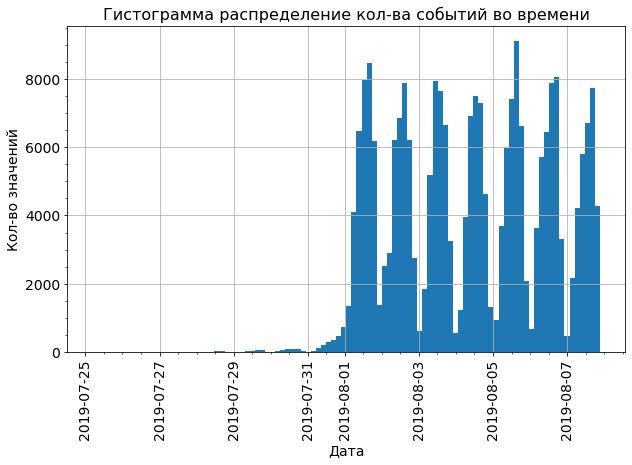

In [80]:
# построим гистограмму 
plt.figure(figsize=(10,6))

plt.hist(data['event_dt'], bins=100, histtype ='bar')
plt.grid()
plt.title('Гистограмма распределение кол-ва событий во времени', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кол-во значений', fontsize=14)

plt.xticks(fontsize=14, rotation='vertical')
plt.minorticks_on()

plt.yticks(fontsize=14)
plt.show();

Минимальная дата: 2019-07-25, однако до 2019-08-01 данных очень мало относительно периода после 1 августа.

Отбросим все данные ранее 2019-08-01.

In [81]:
# запишим данные за полный период в новую переменную data_new
lim_dt = '2019-08-01 00:00:00' # граница между периодом с полными данными и старыми
data_new = data.query('event_dt >= @lim_dt') 

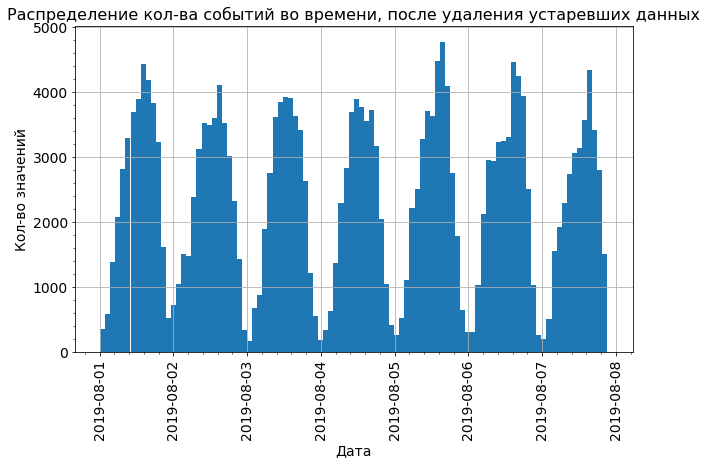

In [82]:
plt.figure(figsize=(10,6))

plt.hist(data_new['event_dt'], bins=100, histtype ='bar')
plt.grid()
plt.title('Распределение кол-ва событий во времени, после удаления устаревших данных', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кол-во значений', fontsize=14)

plt.xticks(fontsize=14, rotation='vertical')
plt.minorticks_on()

plt.yticks(fontsize=14)
plt.show();

In [83]:
print('Минимальная дата:', data_new['event_dt'].min())
print('Ммаксимальная дата:', data_new['event_dt'].max())

Минимальная дата: 2019-08-01 00:07:28
Ммаксимальная дата: 2019-08-07 21:15:17


In [84]:
# посчитаем сколько событий мы потрели, отбросив старые данные 
print('Кол-во отброшеных событий', len(data.query('event_dt < @lim_dt')['event_name']))
print('Процент потери', round(len(data.query('event_dt < @lim_dt')['event_name'])/len(data)*100, 2), '%')


Кол-во отброшеных событий 2826
Процент потери 1.16 %


Теперь посчитаем сколько пользователей мы потеряли:

In [85]:
print('Кол-во уникальных пользователей до фильтрации:', 
      len(data['device_id'].unique()))

print('Кол-во уникальных пользователей, оставшихся после фильтрации:', 
      len(data.query('event_dt >= @lim_dt')['device_id'].unique()))

Кол-во уникальных пользователей до фильтрации: 7551
Кол-во уникальных пользователей, оставшихся после фильтрации: 7534


In [86]:
print('Кол-во потеряных пользователей:', 
      len(data['device_id'].unique()) - len(data.query('event_dt >= @lim_dt')['device_id'].unique()))

Кол-во потеряных пользователей: 17


In [87]:
# проверим как измнилось кол-во уникальных пользователей в группах, после удаления части данных
print('Кол-во уникальных пользователей в группе А1:', len(data_new.query('exp_id == 246')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе А2:', len(data_new.query('exp_id == 247')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе B:', len(data_new.query('exp_id == 248')['device_id'].unique()))

Кол-во уникальных пользователей в группе А1: 2484
Кол-во уникальных пользователей в группе А2: 2513
Кол-во уникальных пользователей в группе B: 2537


In [88]:
# проверим как измнилось кол-во событий в группах, после удаления части данных
print('Кол-во событий в группе А1:', len(data_new.query('exp_id == 246')))
print('Кол-во событий в группе А2:', len(data_new.query('exp_id == 247')))
print('Кол-во событий в группе B:', len(data_new.query('exp_id == 248')))

Кол-во событий в группе А1: 79302
Кол-во событий в группе А2: 77022
Кол-во событий в группе B: 84563


**Выводы**

В исходном датафрейма данные представлены за период с 2019-07-25 по 2019-08-07 включительно. Однако, до 2019-08-01 данные неполные. Данные за этот период были отброшены. Потеря в кол-ве событий составила 1.16%, а в кол-ве уникальных пользователей - 19.22%.

Для дальнейшего исследования будем использовать данные за период с 1 по 7 августа включительно.

Удаление части данных практически не повлияло на кол-во уникальных пользователей в каждой группе. 

По-прежнему в группе В кол-во событий больше, чем в контрольных группах. 

----------------------------------------------------------

## Изучение воронки событий

### Какие события есть в логах, как часто они встречаются

In [89]:
data_new.groupby(by='event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

**Наблюдения**

В логах всречается 5 событий:
* MainScreenAppear - Показ главной страницы
* OffersScreenAppear - Показ страницы предложений
* CartScreenAppear - Показ корзины
* PaymentScreenSuccessful - Показ страницы с сообщением об успешной оплате
* Tutorial - Руководство/Инструкция           

Наиболее частое событие - показ главной страницы.

### Cколько пользователей совершали каждое из этих событий

In [90]:
#сгруперруем данные по названиям событий 
#и посчитаем кол-во этих событий в логе и кол-во уникальных пользователей, совершивших эти события
event_grouped = data_new.groupby(by='event_name')\
                .agg({'event_name': 'count','device_id': 'nunique'})\
                .sort_values(by='device_id', ascending=False)

event_grouped.columns = ['total_event', 'total_users']

event_grouped['proportion_of_users'] = round(event_grouped['total_users']/len(data_new['device_id'].unique())*100, 2)

event_grouped

# total_event - частота встречания события в логе
# total_users - кол-во уникальных пользователей, совершивших событие
# proportion_of_users - доля пользователей от общего кол-ва уникальных пользователей, которые хоть раз совершали событие, в %


,total_event,total_users,proportion_of_users
event_name,,,
MainScreenAppear,117328,7419,98.47
OffersScreenAppear,46333,4593,60.96
CartScreenAppear,42303,3734,49.56
PaymentScreenSuccessful,33918,3539,46.97
Tutorial,1005,840,11.15


**Наблюдения**

Практически все пользователи, зарегистрированные в логе, посетили главную страницу. Около 61% просмотрели страницу с предложениями. Для остальных событий доля ниже 50%. Меньше всего пользователей посетили раздел с инструкциями - 11%. 

### Воронка событий

Скорее всего последовательно совершаются четыре события: 

* Пользователь заходит на главную страницу - MainScreenAppear 
* Смотрит какие предложения есть - OffersScreenAppear 
* Добавляет заказ в корзину и заходит в корзину - CartScreenAppear
* Оплачивает заказ и появляется страница с сообщением об успешной оплате - PaymentScreenSuccessful 

Tutorial скорее всего не обязательный шаг для покупки и открывают инструкцию не всегда.

**Рассчитаем какая доля пользователей проходит на следующий шаг воронки**

In [91]:
# для удобства превратим индексы таблицы event_grouped в столбец 
event_grouped.reset_index(inplace= True )
event_grouped

,event_name,total_event,total_users,proportion_of_users
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


In [92]:
# рассчитаем долю пользователей, перешедших на следующий шаг

for i in range(len(event_grouped)-2): # в расчётах не учитываем строку Tutorial
    event_grouped.loc[i+1,'CR,%'] = round(event_grouped.loc[i+1, 'total_users']/event_grouped.loc[i, 'total_users']*100, 2)
    

In [93]:
event_grouped.loc[0,'CR,%'] = 100 # примем за 100% кол-во пользователей на первом шаге воронки 
event_grouped

,event_name,total_event,total_users,proportion_of_users,"CR,%"
0,MainScreenAppear,117328,7419,98.47,100.00
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78
4,Tutorial,1005,840,11.15,NaN


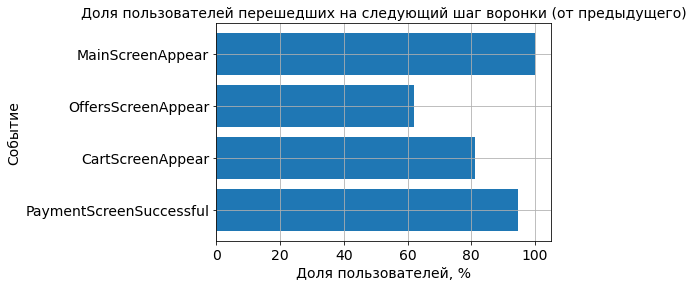

In [94]:
# для наглядности построим столбчатую диаграмму с долями
event_grouped = event_grouped.sort_values(by='total_event')
x=event_grouped['event_name']
y=event_grouped['CR,%']

plt.figure(figsize=(6,4))

plt.barh(x, y)

plt.grid()
plt.xlabel('Доля пользователей, %', fontsize=14)
plt.ylabel('Событие', fontsize=14)
plt.title('Доля пользователей перешедших на следующий шаг воронки (от предыдущего)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show;

In [105]:
#  построение графика воронки событий 
event_grouped = event_grouped.sort_values(by='total_event', ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'proportion_of_users',
    y =  event_grouped.loc[0:3, 'event_name'],
    x = event_grouped.loc[0:3,'total_users'],
    textinfo = "value+percent initial+percent previous")
             )

fig.update_layout(title={'text': "Воронка событий: Доля пользователей перешедших на следующий шаг"})

fig.show()

**Выводы**

Только 62% пользователей зашедших на главную страницу переходят на страницу с предложениями. 

81% пользователей, просмотревших предложения, переходят в корзину. И 95% пользователей, посетивших корзину, совершают успешно заказ. Довольно хорошие показатели, но возможно у тех 5%, которые зашли в корзину и так и не совершили заказ, возникли какие-то технические проблемы. Стоит по выяснять. 

От изначального кол-ва пользователей до финального этапа - успешной оплаты - дошли 48% пользователей. 

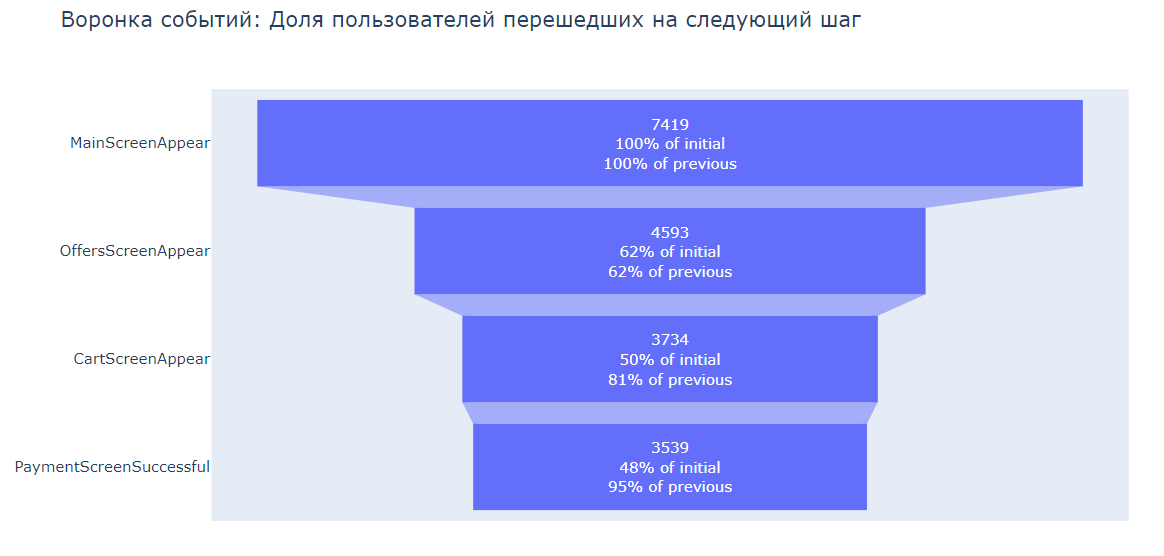

--------------------------------------

## Изучение результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе?


In [96]:
print('Кол-во уникальных пользователей в группе А1:', len(data_new.query('exp_id == 246')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе А2:', len(data_new.query('exp_id == 247')['device_id'].unique()))
print('Кол-во уникальных пользователей в группе B:', len(data_new.query('exp_id == 248')['device_id'].unique()))

Кол-во уникальных пользователей в группе А1: 2484
Кол-во уникальных пользователей в группе А2: 2513
Кол-во уникальных пользователей в группе B: 2537


### Проверка наличия разницы между контрольными выборками 246 и 247

Чтобы проверить есть ли статистически значимые различия между контрольными группами А1 и А2 проведем проверку на равенство долей с помощью z-теста при уровне значимости 0.05.

Нулевая гипотеза: статистически значимых различий между группами А1 (246) и А2 (247) нет.

Альтернативная гипотеза: есть статистически значимые различия между группами.

In [97]:
# зададим критический уровень статистической значимости
alpha = 0.05 

Последовательно проверим различие долей для всех событий:

* MainScreenAppear          
* OffersScreenAppear      
* CartScreenAppear        
* PaymentScreenSuccessful   
* Tutorial    

Начнём с самого популярного события - MainScreenAppear. 

In [98]:
# напишем функцию для проверки 

# входные параметры:
# group1 - номер/а контрольной группы 
# group2 - номер второй сравниваемой группы
# event_list - список событий 


def z_test(group1, group2, event_list):
    
    for e in event_list: # для каждого события из списка производим проверку гипотезы
        
        event = e #  название события 
        
        print('\033[1m'+'Событие:', event+ '\033[0m') # выводим название события жирным шрифтом
        # группа 1
        count_event_1 = len(data_new.query('exp_id in @group1 and event_name==@event')['device_id'].unique()) # число пользователей из группы 1 совершивших событие
        print('Число пользователей из группы', group1, ', совершивших событие', '\033[1m'+event+ '\033[0m', ':', count_event_1)
        
        n1 = len(data_new.query('exp_id in @group1')['device_id'].unique()) # размер первой выборки
        
        p1 = count_event_1/n1 # доля пользователей из группы 1
        print('Доля пользователй относительно общего числа пользователей в группе:', p1)
    
        print('------')
    
        # группа 2
        count_event_2 = len(data_new.query('exp_id == @group2 and event_name==@event')['device_id'].unique()) # число пользователей из группы 2 совершивших событие
        print('Число пользователей из группы', group2, ', совершивших событие', '\033[1m'+event+ '\033[0m', ':', count_event_2)
    
        n2 = len(data_new.query('exp_id == @group2')['device_id'].unique()) # размер второй выборки
    
        p2 = count_event_2/n2 # доля пользователей из группы 2
        print('Доля пользователй относительно общего числа пользователей в группе:', p2)
    
        # пропорция в комбинированном датасете:
        p_combined = (count_event_1 + count_event_2) / (n1 + n2)
    
        # разница пропорций в датасетах
        difference = p1 - p2
    
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
    
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('------')
        print('\033[1m'+'p-значение: '+ '\033[0m', p_value)

        if p_value < alpha:
            print(colored('Отвергаем нулевую гипотезу: между долями есть значимая разница', 'green'))
        else:
            print(colored('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.', 'red')) 

        print('===================================================================================')
    
    return('END')

In [99]:
event_list = event_grouped['event_name'].to_list() # создадим список с названиями событий

In [100]:
# вызовим функцию для проверки равенства долей контрольных групп 

group1 = [246]
group2 = 247
z_test(group1, group2, event_list)


Событие: Tutorial
Число пользователей из группы [246] , совершивших событие Tutorial : 278
Доля пользователй относительно общего числа пользователей в группе: 0.11191626409017713
------
Число пользователей из группы 247 , совершивших событие Tutorial : 283
Доля пользователй относительно общего числа пользователей в группе: 0.11261440509351373
------
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: PaymentScreenSuccessful
Число пользователей из группы [246] , совершивших событие PaymentScreenSuccessful : 1200
Доля пользователй относительно общего числа пользователей в группе: 0.4830917874396135
------
Число пользователей из группы 247 , совершивших событие PaymentScreenSuccessful : 1158
Доля пользователй относительно общего числа пользователей в группе: 0.46080382013529647
------
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: CartScreenAppear
Ч

'END'

**Выводы**

Самым популярным событием является показ главного экрана (MainScreenAppear). После проверки с помощью z-критерия, при уровне значимости 0,05, гипотезы о равенстве долей между группами 246 и 247 для этого события, не получилось отвергнуть нулевую гипотезу. Нет оснований считать доли разными. 

Аналогичная проверка была произведена для остальных четырёх событий. Проверка показала, что, при уровне значимости 0.05, во всех  случаях нет оснований отвергать нулевую гипотезу и считать доли разными. 

Из этого можно сделать вывод, что разбиение на группы работает корректно. 

-----------------------------------------------------------------------------

### Проверка наличия разницы между контрольными группами и эксперементальной

Чтобы проверить есть ли статистически значимые различия между контрольными группами и экспериментальной проведем проверку на равенство долей с помощью z-теста при уровне значимости 0.05.

Н0: статистически значимых различий между группами нет.

Н1: есть статистически значимые различия между группами.

#### Проверка наличия разницы между контрольной группой 246 и эксперементальной  248

In [101]:
# сравниваемые группы
group1 = [246]
group2 = 248

# вызов функции
z_test(group1, group2, event_list) 


Событие: Tutorial
Число пользователей из группы [246] , совершивших событие Tutorial : 278
Доля пользователй относительно общего числа пользователей в группе: 0.11191626409017713
------
Число пользователей из группы 248 , совершивших событие Tutorial : 279
Доля пользователй относительно общего числа пользователей в группе: 0.10997240835632636
------
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: PaymentScreenSuccessful
Число пользователей из группы [246] , совершивших событие PaymentScreenSuccessful : 1200
Доля пользователй относительно общего числа пользователей в группе: 0.4830917874396135
------
Число пользователей из группы 248 , совершивших событие PaymentScreenSuccessful : 1181
Доля пользователй относительно общего числа пользователей в группе: 0.46551044540796216
------
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: CartScreenAppear
Чи

'END'

#### Проверка наличия разницы между контрольной группой 247 и эксперементальной  248

In [102]:
# сравниваемые группы
group1 = [247]
group2 = 248

# вызов функции
z_test(group1, group2, event_list) 


Событие: Tutorial
Число пользователей из группы [247] , совершивших событие Tutorial : 283
Доля пользователй относительно общего числа пользователей в группе: 0.11261440509351373
------
Число пользователей из группы 248 , совершивших событие Tutorial : 279
Доля пользователй относительно общего числа пользователей в группе: 0.10997240835632636
------
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: PaymentScreenSuccessful
Число пользователей из группы [247] , совершивших событие PaymentScreenSuccessful : 1158
Доля пользователй относительно общего числа пользователей в группе: 0.46080382013529647
------
Число пользователей из группы 248 , совершивших событие PaymentScreenSuccessful : 1181
Доля пользователй относительно общего числа пользователей в группе: 0.46551044540796216
------
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: CartScreenAppear
Чи

'END'

#### Проверка наличия разницы между объединённой контрольной группой (246+247) и эксперементальной  248

In [103]:
# сравниваемые группы
group1 = [246, 247]
group2 = 248

# вызов функции
z_test(group1, group2, event_list) 


Событие: Tutorial
Число пользователей из группы [246, 247] , совершивших событие Tutorial : 561
Доля пользователй относительно общего числа пользователей в группе: 0.11226736041624975
------
Число пользователей из группы 248 , совершивших событие Tutorial : 279
Доля пользователй относительно общего числа пользователей в группе: 0.10997240835632636
------
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: PaymentScreenSuccessful
Число пользователей из группы [246, 247] , совершивших событие PaymentScreenSuccessful : 2358
Доля пользователй относительно общего числа пользователей в группе: 0.47188312987792674
------
Число пользователей из группы 248 , совершивших событие PaymentScreenSuccessful : 1181
Доля пользователй относительно общего числа пользователей в группе: 0.46551044540796216
------
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Событие: CartScree

'END'

**Выводы**

После проверки с помощью z-критерия равенства долей между группами 
- 246 и 248,
- 247 и 248
- и объединенной контрольной (246+247) и 248

для всех пяти событий, при уровне значимости 0.05, статистически значимых различий между долями выявлено не было. При данном уровне значимости нет оснований отвергать нулевую гипотезу. 

Всего было сделано 15 проверок статистических гипотез. По три проверки для каждого события. В каждом из сравнений мы могли с вероятностью 5% получить ошибку. При множественном сравнении вероятность ошибиться хотя бы раз за k сравнений равна 1-(1-alpha)^k. То есть в нашем случае вероятность ошибиться около 0.14. Для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез можно применить, например, метод Бонферрони, где alpha делят на кол-во сравнений. В нашем случае было бы 0.05/3 = 0.017. Однако, если мы рассмотрим полученные p-value, то увидим, что все они значительно больше 0.017, и введение поправки не изменит результат проверки гипотез. 


## Общие выводы

Были изучены данные лога за период с 25 июля по 7 августа 2019.
Было выявлено, что в данных присутствуют дубликаты. Они были удалены. Также часть данных из лога была устаревшей. Эти данные были отброшены и в дальнейшем исследовании рассматривались данные за период с 1 по 7 августа 2019 включительно. 

Всего зарегистрировано 243713 событий за исследуемый период.
Эти события подразделяются на 5 типов: 
* MainScreenAppear - Показ главной страницы
* OffersScreenAppear - Показ страницы предложений
* CartScreenAppear - Показ корзины
* PaymentScreenSuccessful - Показ страницы с сообщением об успешной оплате
* Tutorial - Руководство/Инструкция      

В логе присутствуют 7551 уникальных пользователя. 
В среднем на каждого пользователя приходятся 32 события. Однако в данных присутствуют аномальные пользователи, с большим кол-вом событий. Медианное значение - 20 событий на пользователя. 

Наиболее популярное событие - показ главной страницы. Только 61% пользователей после этого переходит на страницу с предложениями. 95% пользователей, добавивших товар в корзину, успешно покупают его. От изначального кол-ва пользователей 48% дошли до успешной оплаты товара. 

Также в ходе исследования были изучены данные А\А\В-теста. 

* Кол-во уникальных пользователей в группе А1 (№246): 2489
* Кол-во уникальных пользователей в группе А2 (№247): 2520
* Кол-во уникальных пользователей в группе B (№248): 2542

Проверка на равенство долей с помощью z-критерия между контрольными группами 246 и 247 показала, что разбиение на группы было произведено корректно. При уровне значимости 0.05 нет статистически значимых различий между двумя контрольными группами для всех пяти событий.

Также, при том же уровне значимости, не было выявлено статистически значимых различий между контрольными группами и экспериментальной. Внедрение нового шрифта никак не сказалось на поведение пользователей. 